In [25]:
%load_ext autoreload
%autoreload 2
import numpy as np
import gym
from main.maml_agent import MAMLAgent, register_flags
from main.alpaca import *
from main.dataset import *
from main.dataViz import *
#register_flags()
import yaml

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:
cfg_filename = 'configs/multistep-config.yml'
with open(cfg_filename,'r') as ymlfile:
    config = yaml.load(ymlfile)

In [56]:
# DG = DataGenerator(config,None,'Multistep')
# N_train = 5000
# N_test = 500
# test_horz = 30
# Y,X,step_mat = DG.sample_trajectories(None,test_horz,N_train,return_lists=True)
# Y_test,X_test,step_mat_test = DG.sample_trajectories(None,test_horz,N_test,return_lists=True)
dataset =  MultistepDataset(config)

## Default agent

In [57]:
g1 = tf.Graph()
sess1 = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True), graph=g1)
agent = ALPaCA(config, sess1, g1)

/home/apoorva/.envs/adapt/lib/python3.5/site-packages/tensorflow/python/client/session.py:1645: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [58]:
agent.construct_model()

In [59]:
agent.train(dataset,5000)

loss: 5.4269066
loss: 0.89084166
loss: 1.0081184
loss: 0.73165476
loss: 0.76687247
loss: 0.3827722
loss: 0.6580904
loss: -0.36033577
loss: -0.22245856
loss: -0.2281994
loss: -0.41214776
loss: -0.62392175
loss: -0.2062812
loss: -0.5651559
loss: -0.49336532
loss: -0.6939148
loss: -0.4618874
loss: -0.7633279
loss: -0.6296639
loss: -0.41319573
loss: -0.7803629
loss: -0.67011976
loss: -0.7263441
loss: -0.7422881
loss: -0.7574194
loss: -0.75173384
loss: -0.8061011
loss: -0.63967746
loss: -0.8029085
loss: -0.7440109
loss: -0.9223292
loss: -0.66447264
loss: -0.72649187
loss: -0.91878074
loss: -0.48659596
loss: -0.32994118
loss: -0.89388406
loss: -0.67937815
loss: -0.7001427
loss: -0.8548187
loss: -0.99279857
loss: -0.64854276
loss: -0.7448019
loss: -0.9306704
loss: -0.7080538
loss: -0.82603747
loss: -0.851526
loss: -0.79553246
loss: -0.95075476
loss: -0.7271873
loss: -0.9204063
loss: -0.78658175
loss: -0.8127904
loss: -0.6535999
loss: -0.8501791
loss: -0.8776017
loss: -0.8308153
loss: -0.73520

## Agent without meta-training

In [60]:
g2 = tf.Graph()
sess2 = tf.Session(config=tf.ConfigProto(log_device_placement=True), graph=g2)
agent_nometa = ALPaCA(config,sess2,g2)
agent_nometa.config['data_horizon'] = 0
agent_nometa.construct_model()

In [61]:
agent_nometa.train(dataset, 5000)

loss: 3.575202
loss: 0.14320487
loss: -0.25361878
loss: -0.27318949
loss: -0.41016513
loss: -0.3542489
loss: -0.4073703
loss: -0.461368
loss: -0.47590226
loss: -0.38883725
loss: -0.4949639
loss: -0.4750254
loss: -0.38611218
loss: -0.46049237
loss: -0.33377722
loss: -0.32138586
loss: -0.5711051
loss: -0.37648326
loss: -0.3703742
loss: -0.44360602
loss: -0.32465538
loss: -0.35816777
loss: -0.5001012
loss: -0.36729565
loss: -0.46565112
loss: -0.4746113
loss: -0.40446842
loss: -0.40254262
loss: -0.50931853
loss: -0.4366758
loss: -0.48603234
loss: -0.53718334
loss: -0.533723
loss: -0.54997444
loss: -0.53947926
loss: -0.42268938
loss: -0.5147658
loss: -0.5027386
loss: -0.6036243
loss: -0.61816156
loss: -0.49649006
loss: -0.5795354
loss: -0.45667744
loss: -0.5767538
loss: -0.5110864
loss: -0.6447177
loss: -0.5387353
loss: -0.45063713
loss: -0.6050726
loss: -0.46280724
loss: -0.61100286
loss: -0.48164317
loss: -0.5418543
loss: -0.55047846
loss: -0.57746387
loss: -0.5043553
loss: -0.5957628
los

## GP regression agent

In [43]:
from main.gp_reg import *

GPR_agent = GPReg()

## MAML agent

In [63]:
g3 = tf.Graph()
sess3 = tf.Session(config=tf.ConfigProto(log_device_placement=True), graph=g3)
maml_agent = MAMLAgent(config, sess3, g3, exp_string="multistep_test1")
maml_agent.construct_model()

using sinusoid arch
INFO:tensorflow:Summary name metatrain_Pre-update loss is illegal; using metatrain_Pre-update_loss instead.
INFO:tensorflow:Summary name metatrain_Post-update loss, step 1 is illegal; using metatrain_Post-update_loss__step_1 instead.
INFO:tensorflow:Summary name metatrain_Post-update loss, step 2 is illegal; using metatrain_Post-update_loss__step_2 instead.
INFO:tensorflow:Summary name metatrain_Post-update loss, step 3 is illegal; using metatrain_Post-update_loss__step_3 instead.
INFO:tensorflow:Summary name metatrain_Post-update loss, step 4 is illegal; using metatrain_Post-update_loss__step_4 instead.
INFO:tensorflow:Summary name metatrain_Post-update loss, step 5 is illegal; using metatrain_Post-update_loss__step_5 instead.


In [64]:
maml_agent.train(dataset, 15000)

Done initializing, starting training.
Iteration 1000: 0.5711105, 0.56834304
Iteration 2000: 0.49731725, 0.51087785
Iteration 3000: 0.48002195, 0.49138457
Iteration 4000: 0.46302295, 0.46143407
Iteration 5000: 0.4403921, 0.4568467
Iteration 6000: 0.4783526, 0.49338397
Iteration 7000: 0.4847869, 0.47257662
Iteration 8000: 0.46726227, 0.46915507
Iteration 9000: 0.4898103, 0.47484332
Iteration 10000: 0.46145216, 0.468426
Iteration 11000: 0.50286025, 0.4504777
Iteration 12000: 0.45241508, 0.45933476
Iteration 13000: 0.46553797, 0.4496222
Iteration 14000: 0.4844173, 0.4419703


# Visualize all agents

In [65]:
N_test = 500
test_horz = 30
X_test,Y_test,step_mat_test = dataset.sample(N_test,test_horz,return_lists=True)

/home/apoorva/.envs/adapt/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'nit': 0, 'grad': array([0., 0., 0.]), 'warnflag': 2, 'task': b'ERROR: NO FEASIBLE SOLUTION', 'funcalls': 0}
  " state: %s" % convergence_dict)
/home/apoorva/.envs/adapt/lib/python3.5/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/apoorva/.envs/adapt/lib/python3.5/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


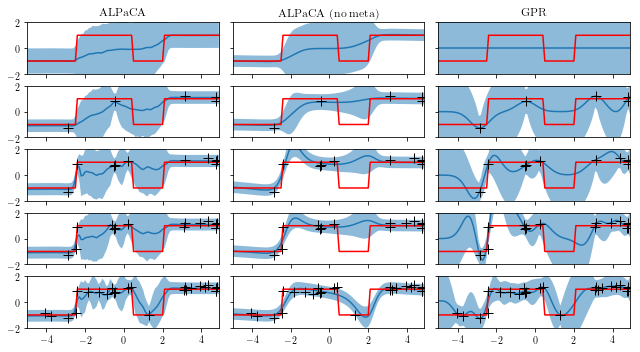

In [66]:
ind = 0
sample_size_list = [0,5,10,15,25]
plt.figure(figsize=(9,len(sample_size_list)*1))
for i,num_pts in enumerate(sample_size_list):
    X_update = X_test[ind:(ind+1),:num_pts,:]
    Y_update = Y_test[ind:(ind+1),:num_pts,:]

    title=None
    legend=False
    if i == 0:
        legend=True
        title=True

    ax1 = plt.subplot(len(sample_size_list),3,3*i+1)
    gen_multistep_fig(agent, X_update, Y_update, step_mat_test[ind,:], label=None)
    if i == 0:
        plt.title('ALPaCA')
    if i < len(sample_size_list) - 1:
        plt.setp(ax1.get_xticklabels(), visible=False)

    ax2 = plt.subplot(len(sample_size_list),3,3*i+2, sharey=ax1)
    gen_multistep_fig(agent_nometa, X_update, Y_update, step_mat_test[ind,:], label=None)
    plt.setp(ax2.get_yticklabels(), visible=False)

    if i == 0:
        plt.title('ALPaCA (no meta)')
    if i < len(sample_size_list) - 1:
        plt.setp(ax2.get_xticklabels(), visible=False)

    ax3 = plt.subplot(len(sample_size_list),3,3*i+3, sharey=ax1)
    gen_multistep_fig(GPR_agent, X_update, Y_update, step_mat_test[ind,:], label=None)
    plt.setp(ax3.get_yticklabels(), visible=False)
    if i == 0:
        plt.title('GPR')
    if i < len(sample_size_list) - 1:
        plt.setp(ax3.get_xticklabels(), visible=False)

plt.tight_layout(w_pad=0.0,h_pad=0.2)
plt.savefig('figures/multistep_three.pdf')
plt.show()

In [67]:
import time
import tqdm

def gaussian_nll(y,mu,Sig):
    #assuming scalars being passed in for now
    n = 1
    logdet = np.log(Sig)
    nll = n*np.log(2*np.pi) + logdet + ((y-mu).T * (1/Sig) * (y-mu))
    return 0.5*nll

def MSE(y,mu):
    return (y-mu)**2

def get_stats(meas, N):
    mean = sum(meas)/N
    var = sum([(nl - mean)**2 for nl in meas])/(N-1)
    return mean, var

alpaca_nll_mean = []
alpaca_nll_var = []
alpaca_time_mean = []
alpaca_time_var = []
alpaca_mse_mean = []
alpaca_mse_var = []

maml_time_mean = []
maml_time_var = []
maml_mse_mean = []
maml_mse_var = []
maml5_mse_mean = []
maml5_mse_var = []

lpaca_nll_mean = []
lpaca_nll_var = []
lpaca_time_mean = []
lpaca_time_var = []

gp_nll_mean = []
gp_nll_var = []
gp_time_mean = []
gp_time_var = []

for j in tqdm.tqdm(range(test_horz)):
    nll_list_alpaca = []
    nll_list_lpaca = []
    nll_list_gp = []
    
    mse_list_alpaca = []
    mse_list_maml = []
    mse_list_maml5 = []

    time_list_alpaca = []
    time_list_maml = []
    time_list_lpaca = []
    time_list_gp = []
    
    for ind in range(N_test):
        X_update = X_test[ind:(ind+1),:j,:]
        Y_update = Y_test[ind:(ind+1),:j,:]
        x_pt = X_test[ind:(ind+1),(j):(j+1),:]
        y_pt = Y_test[ind:(ind+1),(j):(j+1),:]
    
        t1_alpaca = time.process_time()
        y, s = agent.test(X_update, Y_update, x_pt)
        t2_alpaca = time.process_time()
        
        t1_maml = time.process_time()
        y_maml, _ = maml_agent.test(X_update, Y_update, x_pt)
        t2_maml = time.process_time()
        y_maml5, _ = maml_agent.test(X_update, Y_update, x_pt, num_updates=5)
        
        t1_lpaca = time.process_time()
        y_lpaca,s_lpaca = agent_nometa.test(X_update, Y_update, x_pt)
        t2_lpaca = time.process_time()
        
        t1_gp = time.process_time()
        y_gp, s_gp = GPR_agent.test(X_update, Y_update, x_pt)
        t2_gp = time.process_time()    
            
        nll_list_alpaca.append(gaussian_nll(y_pt[0,0,0],y[0,0,0],s[0,0,0,0]))
        nll_list_lpaca.append(gaussian_nll(y_pt[0,0,0],y_lpaca[0,0,0],s_lpaca[0,0,0,0]))
        nll_list_gp.append(gaussian_nll(y_pt[0,0,0],y_gp[0,0,0],s_gp[0,0,0,0]))
        
        time_list_alpaca.append(t2_alpaca - t1_alpaca)
        time_list_lpaca.append(t2_lpaca - t1_lpaca)
        time_list_maml.append(t2_maml - t1_maml)
        time_list_gp.append(t2_gp - t1_gp)
        
        mse_list_alpaca.append(MSE(y_pt[0,0,0],y[0,0,0]))
        mse_list_maml.append(MSE(y_pt[0,0,0], y_maml[0,0,0]))
        mse_list_maml5.append(MSE(y_pt[0,0,0], y_maml5[0,0,0]))
        
    time_mean_alpaca, time_var_alpaca = get_stats(time_list_alpaca,N_test)
    time_mean_lpaca, time_var_lpaca = get_stats(time_list_lpaca,N_test)
    time_mean_maml, time_var_maml = get_stats(time_list_maml,N_test)
    time_mean_gp, time_var_gp = get_stats(time_list_gp,N_test)
    
    mse_mean_alpaca, mse_var_alpaca = get_stats(mse_list_alpaca,N_test)
    mse_mean_maml, mse_var_maml = get_stats(mse_list_maml,N_test)
    mse_mean_maml5, mse_var_maml5 = get_stats(mse_list_maml5,N_test)
    
    nll_mean_alpaca, nll_var_alpaca = get_stats(nll_list_alpaca,N_test)
    nll_mean_lpaca, nll_var_lpaca = get_stats(nll_list_lpaca,N_test)
    nll_mean_gp, nll_var_gp = get_stats(nll_list_gp,N_test)
    
    alpaca_time_mean.append(time_mean_alpaca)
    alpaca_time_var.append(time_var_alpaca)
    
    lpaca_time_mean.append(time_mean_lpaca)
    lpaca_time_var.append(time_var_lpaca)
    
    maml_time_mean.append(time_mean_maml)
    maml_time_var.append(time_var_maml)
    
    gp_time_mean.append(time_mean_gp)
    gp_time_var.append(time_var_gp)
    
    alpaca_mse_mean.append(mse_mean_alpaca)
    alpaca_mse_var.append(mse_var_alpaca)
    
    maml_mse_mean.append(mse_mean_maml)
    maml_mse_var.append(mse_var_maml)
    
    maml5_mse_mean.append(mse_mean_maml5)
    maml5_mse_var.append(mse_var_maml5)
    
    alpaca_nll_mean.append(nll_mean_alpaca)
    alpaca_nll_var.append(nll_var_alpaca)
    
    lpaca_nll_mean.append(nll_mean_lpaca)
    lpaca_nll_var.append(nll_var_lpaca)
    
    gp_nll_mean.append(nll_mean_gp)
    gp_nll_var.append(nll_var_gp)

  3%|▎         | 1/30 [00:03<01:38,  3.40s/it]/home/apoorva/.envs/adapt/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'nit': 0, 'grad': array([0., 0., 0.]), 'warnflag': 2, 'task': b'ERROR: NO FEASIBLE SOLUTION', 'funcalls': 0}
  " state: %s" % convergence_dict)
100%|██████████| 30/30 [03:17<00:00,  6.59s/it]


/home/apoorva/.envs/adapt/lib/python3.5/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/apoorva/.envs/adapt/lib/python3.5/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


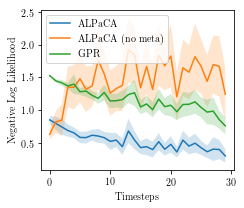

In [68]:
plt.figure(figsize=(3.5,3))
nll_plot(alpaca_nll_mean,alpaca_nll_var,lpaca_nll_mean,lpaca_nll_var,gp_nll_mean,gp_nll_var,N_test,legend=True)
plt.tight_layout()
plt.savefig('figures/nll_multistep.pdf')
plt.show()

/home/apoorva/.envs/adapt/lib/python3.5/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/apoorva/.envs/adapt/lib/python3.5/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


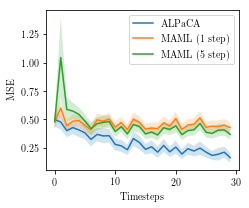

In [69]:
plt.figure(figsize=(3.5,3))
mse_plot(alpaca_mse_mean,alpaca_mse_var,maml_mse_mean,maml_mse_var,maml5_mse_mean,maml5_mse_var,N_test,legend=True)
plt.tight_layout()
plt.savefig('figures/mse_multistep.pdf')
plt.show()

/home/apoorva/.envs/adapt/lib/python3.5/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/apoorva/.envs/adapt/lib/python3.5/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


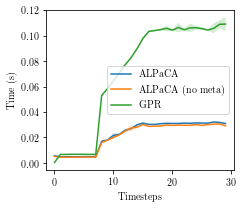

In [71]:
plt.figure(figsize=(3.5,3))
time_plot(alpaca_time_mean,alpaca_time_var,lpaca_time_mean,lpaca_time_var,gp_time_mean,gp_time_var,N_test,legend=True)
plt.tight_layout()
plt.savefig('figures/time_multistep.pdf')
plt.show()